In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
sys.path.append('./data/')
sys.path.append('./models/')

from baseline import *
import pickle
with open('./data/dict_data_final.pkl', 'rb') as f:
    data = pickle.load(f)

# Data

In [2]:
__, y = data['Beneixama']
x = pd.read_csv('data_beneixama.csv', index_col=0)
x['Train'] = __['Train'].values

In [3]:
x.iloc[12]

Theta          2.199115
Rho              0.9045
Temperatura        31.5
Humedad            44.0
Train             False
Name: 20:00:00, dtype: object

# Parameters

In [4]:
list_P = [
    [0, 0.1, 0.5, 0.9, 1.01],
    [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01],
    [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.01],
]
list_C = [1, 1.5, 2, 2.5, 3, 4, 5]

# 1. Study

Hay una desequilibrio entre el número de celdas de la clase susceptible, comparado con las otras.

In [5]:
y1 = (y[:, :, -1] == 0)
y2 = (y[:, :, -1] != 0)

y1.sum()/(y1.shape[0]*y1.shape[1])*100, y2.sum()/(y2.shape[0]*y2.shape[1])*100

(97.76529546245969, 2.234704537540311)

El 97% de las celdas son susceptibles. Luego hay que tener en cuenta este aspecto a la hora de valorar nuestro y estudiar la precisión de nuestro modelo.

## 1.0. Exploratory Analysis

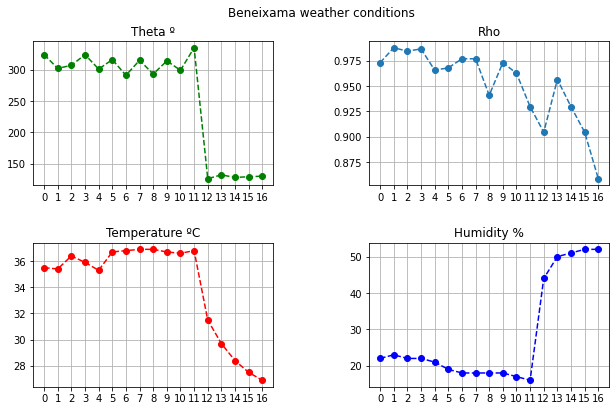

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax[0, 0].plot(x.Theta.values*(180/(np.pi)), 'g--', marker='o')
ax[0, 1].plot(x.Rho.values, 'p--', marker='o')
ax[0, 0].set_title('Theta º')
ax[0, 1].set_title('Rho')
ax[1, 0].plot(x.Temperatura.values, 'r--', marker='o')
ax[1, 1].plot(x.Humedad.values, 'b--', marker='o')
ax[1, 0].set_title('Temperature ºC')
ax[1, 1].set_title('Humidity %')
# introduce grid lines
ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()
# set the spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# set the unique x axis
ax[0, 0].set_xticks(np.arange(0, 17, 1))
ax[0, 1].set_xticks(np.arange(0, 17, 1))
ax[1, 0].set_xticks(np.arange(0, 17, 1))
ax[1, 1].set_xticks(np.arange(0, 17, 1))

fig.suptitle('Beneixama weather conditions')
fig.savefig('figures\weather.png', format='png', dpi=1000)
fig.savefig('figures\weather.eps', format='eps', dpi=1000)
plt.show()

In [7]:
sus_y = np.array([(y[:, :, i] != 0).sum().item() for i in range(y.shape[2])])
abs_y = np.argwhere(x.Train.values == True).flatten()

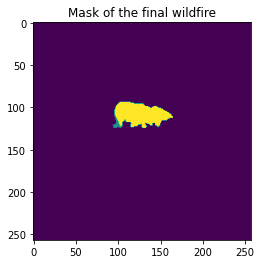

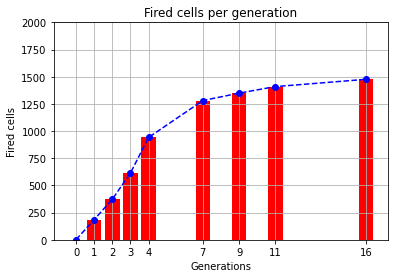

In [8]:
plt.imshow(y[:, :, -1], cmap='viridis')
plt.title('Mask of the final wildfire')
plt.savefig('figures\mask_final.eps', format='eps', dpi=100)
plt.savefig('figures\mask_final.png', format='png', dpi=1000)
plt.show()
plt.bar(abs_y, sus_y, color='r')
plt.plot(abs_y, sus_y, 'b--', marker='o')
plt.xticks(abs_y)
plt.xlabel('Generations')
plt.ylabel('Fired cells')
plt.ylim(0, 2000)
plt.grid()
plt.title('Fired cells per generation')
plt.savefig('figures\cells_fired_bars.eps', format='eps', dpi=1000)
plt.savefig('figures\cells_fired_bars.png', format='png', dpi=1000)
plt.show()

## 1.1. Bernoulli

In [9]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[2], div=list_C[2])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

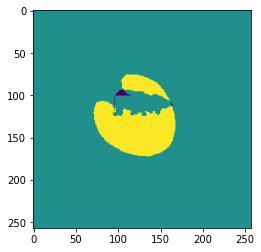

In [10]:
from sklearn.metrics import confusion_matrix

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_errors(X, Y, name='mask_errors'):
    """
    Crea un gráfico mostrando los errores en la comparación entre X e Y.
    
    Parametros:
        X (numpy array): Primera matriz binaria.
        Y (numpy array): Segunda matriz binaria.
    """

    # Verificar que X e Y tengan las mismas dimensiones
    assert X.shape == Y.shape, "X e Y deben tener las mismas dimensiones."

    # Calcular la diferencia entre X e Y para obtener los diferentes tipos de errores
    diff = X - Y

    # Asignar colores específicos a cada tipo de error
    cmap = plt.cm.colors.ListedColormap(['red', 'green', 'blue'])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

    # Crear la imagen del gráfico con colores personalizados
    plt.imshow(diff, cmap=cmap, norm=norm)

    # Crear una leyenda para los tipos de errores
    legend_labels = ['Correct', 'FN', 'FP']
    colors = ['green', 'red', 'blue']
    patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
    plt.legend(patches, legend_labels, loc='upper right')
    plt.savefig(name , format='eps', dpi=300)

    # Mostrar el gráfico
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


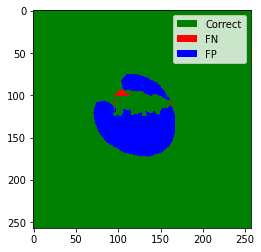

In [12]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[2], div=list_C[2])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plot_confusion_errors(X, Y, name='figures\mask_errors_p2.eps')

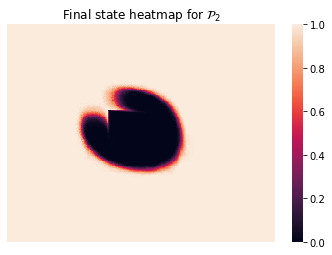

In [13]:
sns.heatmap(grid.X0[:, :, -1].numpy())
# remove axis values
plt.xticks([])
plt.yticks([])
plt.title('Final state heatmap for ' + r'$\mathcal{P}_2$')
plt.savefig('figures\heatmap_p2.eps', format='eps', dpi=300)
plt.savefig('figures\heatmap_p2.png', format='png', dpi=300)

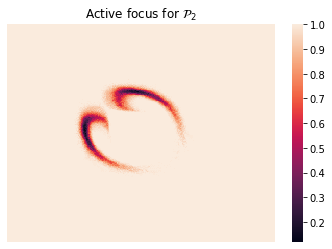

In [14]:
sns.heatmap(1 - grid.X1[:, :, -1].numpy())
# remove axis values
plt.xticks([])
plt.yticks([])
plt.title('Active focus for ' + r'$\mathcal{P}_2$')
plt.savefig('figures\p2_focus_active.eps', format='eps', dpi=300)
plt.savefig('figures\p2_focus_active.png', format='png', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


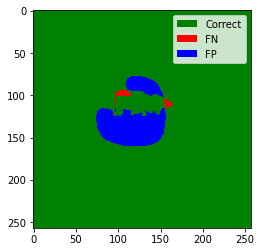

In [15]:
grid = Grid(x=x, y=y)
grid.initialize(part=list_P[1], div=list_C[1])
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plot_confusion_errors(X, Y, name='figures\mask_errors_p1.eps')

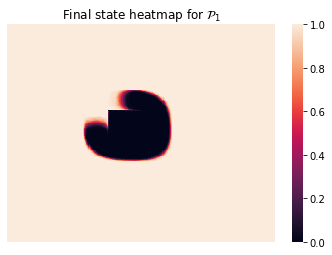

In [16]:
sns.heatmap(grid.X0[:, :, -1].numpy())
# remove axis values
plt.xticks([])
plt.yticks([])
plt.title('Final state heatmap for ' + r'$\mathcal{P}_1$')
plt.savefig('figures\heatmap_p1.eps', format='eps', dpi=300)
plt.savefig('figures\heatmap_p1.png', format='png', dpi=300)

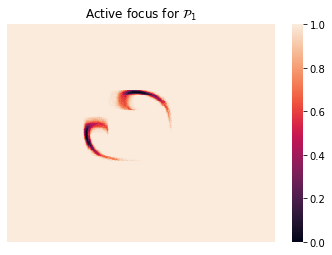

In [18]:
sns.heatmap(1 - grid.X1[:, :, -1].numpy())
# remove axis values
plt.xticks([])
plt.yticks([])
plt.title('Active focus for ' + r'$\mathcal{P}_1$')
plt.savefig('figures\p1_focus_active.eps', format='eps', dpi=300)
plt.savefig('figures\p1_focus_active.png', format='png', dpi=300)

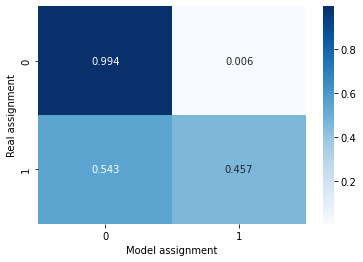

In [8]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef

# compute the confusion matrix of X e Y

cmat = confusion_matrix(Y.flatten(), X.flatten(), normalize='true')
total = np.sum(cmat)
sns.heatmap(cmat, annot=True, cmap='Blues', fmt='.3f')
plt.xlabel('Model assignment')
plt.ylabel('Real assignment')
plt.show()

## 1.2. Gumbel

In [9]:
grid_g = Grid(x=x, y=y, mode='gumbel')
grid_g.initialize(part=list_P[2], div=list_C[-2])
grid_g.submatrix()
grid_g.enlargement_process()
grid_g.montecarlo(n_it=100)

In [10]:
sus_X = np.array([(grid.X[:, :, i] != 0).sum().item() for i in range(grid.X.shape[2])])
sus_X_g = np.array([(grid_g.X[:, :, i] != 0).sum().item() for i in range(grid_g.X.shape[2])])
sus_y = np.array([(grid.y[:, :, i] != 0).sum().item() for i in range(grid.y.shape[2])])

abs_X = range(len(sus_X))
abs_y = np.argwhere(x.Train.values == True).flatten()

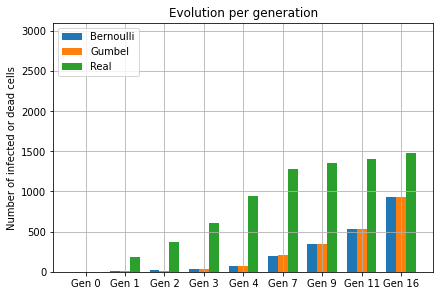

In [11]:
mode = ['Gen ' + str(i) for i in abs_y]
values = {
    'Bernoulli': sus_X[abs_y],
    'Gumbel': sus_X_g[abs_y],
    'Real': sus_y
}

x_ = np.arange(len(mode))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x_ + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of infected or dead cells')
ax.set_title('Evolution per generation')
ax.set_xticks(x_ + width, mode)
ax.legend(loc='upper left')
ax.set_ylim(0, 2000)
ax.grid()

plt.show()

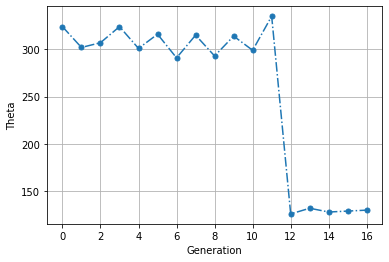

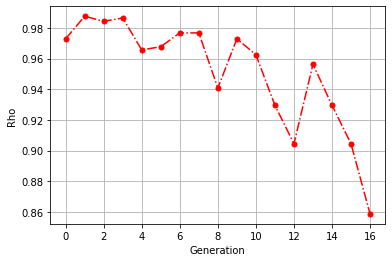

In [12]:
plt.plot(x.Theta.values*180/np.pi, '-.o', markersize=5)
plt.grid()
plt.xlabel('Generation')
plt.ylabel('Theta')
#plt.savefig('theta.png', dpi=300)
plt.show()
plt.plot(x.Rho.values, 'r-.o', markersize=5)
plt.grid()
plt.xlabel('Generation')
plt.ylabel('Rho')
#plt.savefig('rho.png', dpi=300)
plt.show()

# 3. Compute by means of loss factors

In [13]:
w = torch.where(
    torch.from_numpy(y[:, :, -1] == 0),
    torch.from_numpy(y[:, :, -1] != 0).sum(),
    torch.from_numpy(y[:, :, -1] == 0).sum()
)/(257**2)

##### loss & metrics #####

loss = nn.BCELoss(weight=w.flatten().reshape(-1, 1))
y_t = torch.tensor(y, dtype=torch.float32)

l_b = loss(
    torch.stack(
            [grid.X0[:, :, -1].flatten(), 1 - grid.X0[:, :, -1].flatten()], 
            dim=-1
        ).float(),
        torch.stack(
            [((y_t[:, :, -1] == 0)*1).flatten(), ((y_t[:, :, -1] != 0)*1).flatten()],
            dim=-1
        ).float()
).clone().item()

l_g = loss(
    torch.stack(
            [grid_g.X0[:, :, -1].flatten(), 1 - grid_g.X0[:, :, -1].flatten()], 
            dim=-1
        ).float(),
        torch.stack(
            [((y_t[:, :, -1] == 0)*1).flatten(), ((y_t[:, :, -1] != 0)*1).flatten()],
            dim=-1
        ).float()
).clone().item()

In [14]:
print('Bernoulli loss: ', l_b)
print('Gumbel loss: ', l_g)

Bernoulli loss:  0.6828393340110779
Gumbel loss:  0.710366427898407


In [15]:
data_loss = np.zeros((len(list_P), len(list_C), 2))
for i, part in enumerate(list_P):
    for j, c in enumerate(list_C):

        print('Part: ', part, ' Div: ', c)

        grid = Grid(x=x, y=y)
        grid.initialize(part=part, div=c)
        grid.submatrix()
        grid.enlargement_process()
        grid.montecarlo(n_it=100)

        
        grid_g = Grid(x=x, y=y, mode='gumbel')
        grid_g.initialize(part=part, div=c)
        grid_g.submatrix()
        grid_g.enlargement_process()
        grid_g.montecarlo(n_it=100)

        l_b = loss(
            torch.stack(
                    [grid.X0[:, :, -1].flatten(), 1 - grid.X0[:, :, -1].flatten()], 
                    dim=-1
                ).float(),
                torch.stack(
                    [((y_t[:, :, -1] == 0)*1).flatten(), ((y_t[:, :, -1] != 0)*1).flatten()],
                    dim=-1
                ).float()
        )

        l_g = loss(
            torch.stack(
                    [grid_g.X0[:, :, -1].flatten(), 1 - grid_g.X0[:, :, -1].flatten()], 
                    dim=-1
                ).float(),
                torch.stack(
                    [((y_t[:, :, -1] == 0)*1).flatten(), ((y_t[:, :, -1] != 0)*1).flatten()],
                    dim=-1
                ).float()
        )

        data_loss[i, j, 0] = l_b.clone().item()
        data_loss[i, j, 1] = l_g.clone().item()

        
        print('Bernoulli loss: ', l_b.clone().item())
        print('Gumbel loss: ', l_g.clone().item())

Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  1
Bernoulli loss:  0.8453402519226074
Gumbel loss:  0.8208049535751343
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  1.5
Bernoulli loss:  0.7733964920043945
Gumbel loss:  0.7746365666389465
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  2
Bernoulli loss:  0.7789738774299622
Gumbel loss:  0.7997551560401917
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  2.5
Bernoulli loss:  0.8464807271957397
Gumbel loss:  0.8593462109565735
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  3
Bernoulli loss:  0.9506329298019409
Gumbel loss:  0.9179727435112
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  4
Bernoulli loss:  1.0806915760040283
Gumbel loss:  1.086684226989746
Part:  [0, 0.1, 0.5, 0.9, 1.01]  Div:  5
Bernoulli loss:  1.1578882932662964
Gumbel loss:  1.1814366579055786
Part:  [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01]  Div:  1
Bernoulli loss:  0.41700029373168945
Gumbel loss:  0.42582112550735474
Part:  [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.01]  Div:  1.5
Bernoulli loss:  0.185409277677536
Gumbel loss:  0.1948

In [16]:
data_loss[:, :, 0]

array([[0.84534025, 0.77339649, 0.77897388, 0.84648073, 0.95063293,
        1.08069158, 1.15788829],
       [0.41700029, 0.18540928, 0.23511294, 0.43822142, 0.62697387,
        0.8383795 , 1.05217278],
       [0.86600477, 0.37220591, 0.12732276, 0.2252672 , 0.35009986,
        0.68283933, 0.93666625]])

In [17]:
data_loss[:, :, 1]

array([[0.82080495, 0.77463657, 0.79975516, 0.85934621, 0.91797274,
        1.08668423, 1.18143666],
       [0.42582113, 0.19480549, 0.28640577, 0.41206083, 0.59826922,
        0.82888997, 0.99615085],
       [0.86709458, 0.37946337, 0.12991382, 0.13890535, 0.38226178,
        0.71036643, 0.96738106]])

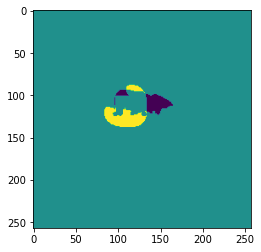

In [18]:
part = list_P[0]
c = list_C[1]


grid = Grid(x=x, y=y)
grid.initialize(part=part, div=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

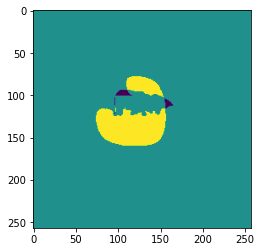

In [19]:
part = list_P[1]
c = list_C[1]


grid = Grid(x=x, y=y)
grid.initialize(part=part, div=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

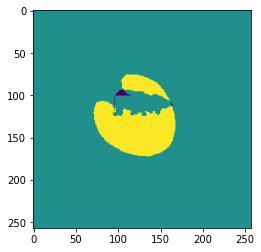

In [20]:
part = list_P[2]
c = list_C[2]


grid = Grid(x=x, y=y)
grid.initialize(part=part, div=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

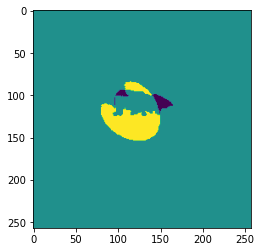

In [21]:
part = list_P[2]
c = list_C[3]


grid = Grid(x=x, y=y)
grid.initialize(part=part, div=c)
grid.submatrix()
grid.enlargement_process()
grid.montecarlo(n_it=100)

X = (grid.X[:, :, -1].numpy() != 0)*1
Y = (y[:, :, -1] != 0)*1

plt.imshow(X-Y)

<AxesSubplot:>

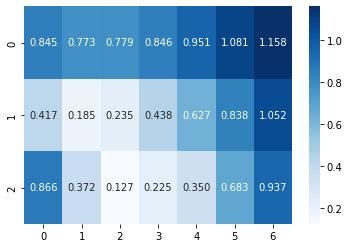

In [22]:
sns.heatmap(data_loss[:, :, 0], annot=True, fmt='.3f', cmap='Blues')

<AxesSubplot:>

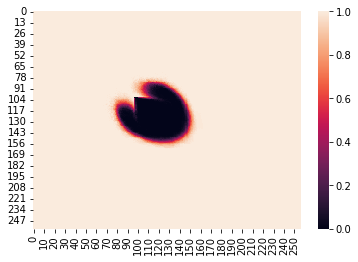

In [23]:
sns.heatmap(grid.X0[:, :, -1].numpy())

In [29]:
import torch
from sklearn.metrics import f1_score

# Supongamos que tienes las etiquetas verdaderas y las predicciones de tu modelo
true_labels = torch.tensor([0, 1, 1, 0, 1])
predicted_labels = torch.tensor([0, 1, 0, 0, 1])

# Calcula el F1-score ponderado
weighted_f1 = f1_score(true_labels.cpu().numpy(), predicted_labels.cpu().numpy(), average='weighted')

print("Weighted F1-score:", weighted_f1)

Weighted F1-score: 0.8


In [40]:
from sklearn.metrics import f1_score, balanced_accuracy_score, accuracy_score

print('F1-score W: ', f1_score(y_true=Y.flatten(), y_pred=X.flatten(), average='weighted').__format__('.3f'))
print('Balanced accuracy: ', balanced_accuracy_score(y_true=Y.flatten(), y_pred=X.flatten()).__format__('.3f'))

F1-score W:  0.969
Balanced accuracy:  0.870
